In [1]:
import os, sys


In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import numpy as np
import seaborn
seaborn.set()

In [3]:
# add to path
sys.path.append("../..")
from filterflow.filter import ParticleFilter
from filterflow.base import State, ObservationBase, InputsBase
from filterflow.observation.linear import LinearObservation, LinearObservationModel
from filterflow.transition.random_walk import RandomWalkModel
from filterflow.proposal.base import BootstrapProposalModel
from filterflow.resampling.criterion import NeffCriterion, AlwaysResample
from filterflow.resampling.standard.systematic import SystematicResampler
from filterflow.resampling.standard.multinomial import MultinomialResampler
from filterflow.resampling.base import NoResampling

In [4]:
class GHMMOutput(object):
    __slots__ = ('observations', 'states')
    def __init__(self, observations: np.ndarray, states: np.ndarray):
        self.observations = observations
        self.states = states

# Definition of the dynamic model
class GHMM(object):
    def __init__(self, 
                 initial_state: np.ndarray,
                 transition_matrix: np.ndarray, 
                 transition_covariance: np.ndarray,
                 observation_matrix: np.ndarray,
                 observation_covariance: np.ndarray,
                 seed: int = None):
        """
        Construction method
        Parameters
        ----------

        """
        self.dim = initial_state.shape[0]
        self.initial_state = initial_state
                
        self.transition_matrix = transition_matrix
        self.transition_covariance = transition_covariance
        
        self.observation_matrix = observation_matrix
        self.observation_covariance = observation_covariance
        
        self.random_seed = seed
                
    def sample_latent_state(self, T):
        latent_state = self.initial_state
        random_samples =  np.random.multivariate_normal(np.repeat(0., self.dim), self.transition_covariance, T)
        
        latent_state_ts = []
        latent_state_ts.append(latent_state)
        for i, random_sample in enumerate(random_samples):
            latent_state = self.transition_matrix @ latent_state
            latent_state += random_sample
            latent_state_ts.append(latent_state)
        return np.array(latent_state_ts)
        
    def get_observation(self, latent_space_ts):
        T = latent_space_ts.shape[0]
        no_noise = np.einsum('ij,kj->ki', self.observation_matrix, latent_space_ts)
        return no_noise + np.random.multivariate_normal(np.repeat(0., self.dim), self.observation_covariance, T)
    
    def sample(self, N: int) -> GHMMOutput:
        """
        Samples n steps of the model
        Parameters
        ----------
        N: int
            total number of steps
        
        Returns
        -------
        ResonatorOutput from the parametrised process
        """
        latent_time_series = self.sample_latent_state(N)
        observations = self.get_observation(latent_time_series)
        return GHMMOutput(observations, latent_time_series)

In [5]:
dim = 2
T = 150
initial_state          = np.repeat(0., dim)
transition_matrix      = np.eye(dim) * 0.5
transition_covariance  = np.eye(dim) * 0.5
observation_matrix     = np.eye(dim) *0.5
observation_covariance = np.eye(dim)*0.1

In [6]:
linear_ss = GHMM(initial_state=initial_state, 
                 transition_matrix=transition_matrix,
                 transition_covariance=transition_covariance,
                 observation_matrix=observation_matrix,
                 observation_covariance=observation_covariance)

In [7]:
ghmm_output = linear_ss.sample(T)
linspace  = np.arange(ghmm_output.observations[:,0].shape[0])


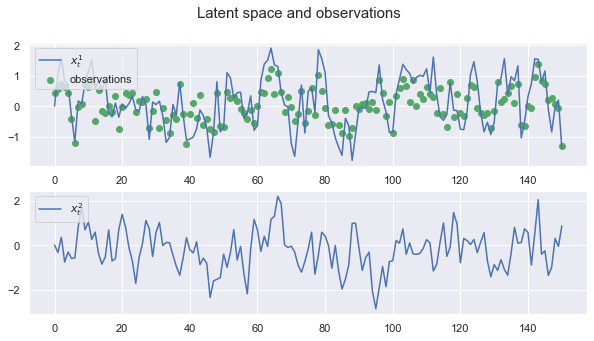

In [8]:
fig, axes = plt.subplots(nrows=2, figsize=(10, 5))
axes[0].scatter(linspace, ghmm_output.observations[:,0], marker='o', color='g', label='observations')
axes[0].plot(ghmm_output.states[:, 0], color='b', label='$x^1_t$')
axes[1].plot(ghmm_output.states[:, 1], color='b', label='$x^2_t$')
_ = axes[0].legend(loc='upper left')
_ = axes[1].legend(loc='upper left')
_ = fig.suptitle('Latent space and observations', fontsize=15)

In [9]:
observation_error = tfd.MultivariateNormalFullCovariance(np.array([0.,0.], dtype = np.float32),
                                                         linear_ss.observation_covariance.astype(np.float32))


observation_model = LinearObservationModel(tf.constant(linear_ss.observation_matrix.astype(np.float32)), 
                                           observation_error)

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


In [10]:
transition_noise = tfd.MultivariateNormalFullCovariance(np.array([0., 0.], dtype=np.float32), 
                                                      linear_ss.transition_covariance.astype(np.float32))

transition_model = RandomWalkModel(tf.constant(linear_ss.transition_matrix.astype(np.float32)), 
                                   transition_noise)

proposal_model = BootstrapProposalModel(transition_model)

In [11]:
resampling_criterion = AlwaysResample()
resampling_method = MultinomialResampler()

In [12]:
particle_filter = ParticleFilter(observation_model, 
                                 transition_model, proposal_model, resampling_criterion, resampling_method)

In [14]:
import time

n_particles = 10**3
batch_size = 1
    
weights = tf.ones((batch_size, n_particles), dtype= np.float32)/n_particles
initial_particles = tf.random.uniform((batch_size, n_particles, dim), -1, 1)
state = State(batch_size, n_particles, dim, initial_particles, weights=weights, check_shapes=True)

# forward run
record_states = []
time.sleep(0.5)
for t, observation_value in enumerate(ghmm_output.observations):
    observation = LinearObservation(tf.constant(np.array([observation_value], dtype=np.float32)), dim)
    input_ = None
    state = particle_filter.propose_and_update(state, observation, input_)
    record_states.append(state)
    

x


In [15]:
# compute states
computed_states = []
for state in record_states:
    log_weights = state.log_weights.numpy()
    particles = state.particles.numpy()[:,:,0]
    weights = np.exp(log_weights)
    computed_state = np.sum((weights * particles), axis=1)
    computed_states.append(computed_state)
    
computed_states = np.array(computed_states).flatten()

In [16]:
import numpy as np
import bqplot.pyplot as bplt
from bqplot import LinearScale, Axis, Lines, Bars, Figure
axes_options = {'x': {'label': 't'}, 'y': {'label': 'y'}}
fig = bplt.figure(animation_duration=0)
lines = bplt.plot(
                x=np.linspace(0, len(ghmm_output.observations), len(ghmm_output.observations)), 
                y=ghmm_output.observations[:,0], 
                colors=['red'], 
                axes_options=axes_options)

if False:
    true_state_ln = bplt.plot(
                x=np.linspace(0, len(ghmm_output.observations), len(ghmm_output.observations)), 
                y=ghmm_output.states[:,0], 
                colors=['blue'], 
                axes_options=axes_options)

computed_lin = bplt.plot(
                x=np.linspace(0, len(ghmm_output.observations), len(ghmm_output.observations)), 
                y=computed_states, 
                colors=['green'], 
                axes_options=axes_options)

scatt = bplt.scatter([], [], colors=['blue'], axes_options=axes_options)


max_y = np.max([computed_states,ghmm_output.observations[:,0]])
min_y = np.min([computed_states,ghmm_output.observations[:,0]])

bplt.set_lim(min_y-0.5, max_y+0.5, 'y')
bplt.set_lim(0, len(ghmm_output.observations), 'x')

fig

Figure(axes=[Axis(label='t', scale=LinearScale(max=151.0, min=0.0)), Axis(label='y', orientation='vertical', s…

In [ ]:
jitter = np.random.normal(0., 0.25, n_particles)

for t, state in enumerate(record_states):
    t += 1
    log_weights = state.log_weights.numpy()
    particles = state.particles.numpy()[0,:,0]
    weights = np.exp(log_weights)
    scatt.x = t + jitter
    scatt.y = particles
    scatt.s = 0.# weights * 100.
    time.sleep(0.3)
    